In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from quspin.basis import spin_basis_1d
from quspin.operators import hamiltonian

from quri_parts.core.operator import Operator, pauli_label, get_sparse_matrix


In [ ]:
def exact_hamiltonian(J, h):
    L = 12
    basis_ising = spin_basis_1d(L=L,)

    Jxx_list = [[-J, j,(j+1)%L] for j in range(L)] 
    hz_list = [[-h, j] for j in range(L)]

    # define Hamiltonian terms
    H_terms = [
        ['xx', Jxx_list],
        ['z', hz_list],
    ]
    
    H_Ising = hamiltonian(H_terms,[], basis=basis_ising)
    return H_Ising


def construct_TFIM_hamiltonian(J, h, n_qubits):
    hamiltonian = Operator()

    # Add Ising interaction terms (-J Σ X_i X_{i+1}) (Assuming periodic boundary conditions)
    for i in range(n_qubits):
        pauli_index = pauli_label('X'+str(i)+' X'+str((i+1)%n_qubits))
        hamiltonian.add_term(pauli_index, -J)

    # Add transverse field terms (-h Σ Z_i)
    for i in range(n_qubits):
        pauli_index = pauli_label('Z'+str(i))
        hamiltonian.add_term(pauli_index, -h)

    return hamiltonian

h = construct_TFIM_hamiltonian(2, 4, 12)
print(np.sum(np.abs(get_sparse_matrix(h) - exact_hamiltonian(2, 4).toarray())))

Hermiticity check passed!
Symmetry checks passed!
0.0


In [ ]:
h_J = np.linspace(0.1, 5, 30)
exact_ground_state = []

In [ ]:
from quri_parts.core.state import QuantumStateVector

L = 12

def convert_to_qsv(ground_state):
    vec = np.zeros(2**L)
    coeff, cb_states = ground_state[0]

    for i in range(len(coeff)):
        vec[cb_states[i].bits] = coeff[i]

    qsv = QuantumStateVector(L, vec)
    return qsv

In [ ]:
state = QuantumStateVector(12, 1/2**12 * np.ones(2**12))
state

QuantumStateVector(n_qubits=12, vector=[0.00024414+0.j 0.00024414+0.j 0.00024414+0.j ... 0.00024414+0.j
 0.00024414+0.j 0.00024414+0.j], circuit=<quri_parts.rust.circuit.circuit.ImmutableQuantumCircuit object at 0x11e5b8990>)

In [ ]:
E, V = exact_hamiltonian(1, 0).eigh()
psi_GS = V[:, 0]
print(E[0]) 

Hermiticity check passed!
Symmetry checks passed!
-11.999999999999973


In [ ]:
print(psi_GS - 1/(2**12) * np.ones(2**12))

[-0.02231611+0.j  0.00080918+0.j  0.00080918+0.j ...  0.00080918+0.j
  0.00080918+0.j -0.02231611+0.j]


In [ ]:
vals, vecs = np.linalg.eigh(exact_hamiltonian(1, 0).toarray())
print(vals[0])
print(vecs[0] - 1/(2**12) * np.ones(2**12))

Hermiticity check passed!
Symmetry checks passed!
-11.999999999999993
[-0.02234123+0.j -0.00024414+0.j -0.00024414+0.j ... -0.00024414+0.j
  0.00079625+0.j  0.02182844+0.j]


In [ ]:
print(vecs[0] - psi_GS)

[ 0.        +0.j -0.00210664+0.j -0.00105353+0.j ... -0.03054692+0.j
  0.00047332+0.j  0.04411626+0.j]


In [ ]:
vals, vecs = scipy.linalg.eigh(exact_hamiltonian(1, 0).toarray())
print(vals[0])
print(vecs[0] - 1/(2**12) * np.ones(2**12))

Hermiticity check passed!
Symmetry checks passed!
-11.999999999999973
[-0.02231611+0.j -0.00129746+0.j -0.00024435+0.j ... -0.02973774+0.j
  0.0012825 +0.j  0.02180015+0.j]


In [ ]:
C_r(QuantumStateVector(12, psi_GS), 2)

(0.7426511888293824+0j)

In [ ]:
C_r(QuantumStateVector(12, val[0]), 2)

(-0.009418354318451885+0j)

In [ ]:
C_r(QuantumStateVector(12, 1/(2**12) * np.ones(2**12)), 2)

(0.00020285447438557944+0j)

In [ ]:
L = 12

from quri_parts.qulacs.estimator import create_qulacs_vector_estimator
from quri_parts.core.operator import Operator, pauli_label, get_sparse_matrix

qulacs_estimator = create_qulacs_vector_estimator()

magnetization_operator = Operator()
for i in range(L):
    pauli_index = pauli_label('Z'+str(i))
    magnetization_operator.add_term(pauli_index, 1)

def calculate_magnetization(quantum_state):
    return 1/L * np.real(qulacs_estimator(magnetization_operator, quantum_state))[0]
    

In [ ]:

from quri_parts.core.operator import Operator, pauli_label, get_sparse_matrix

def C_r(quantum_state, r):
    pair_corr_operator = Operator()
    for i in range(L):
        if i +r >= L:
             break
        pauli_index = pauli_label('X'+str(i)+' X'+str(i+r))
        pair_corr_operator.add_term(pauli_index, 1)  

    normal_corr_operator = Operator()
    for i in range(L):
        pauli_index = pauli_label('X'+str(i))
        normal_corr_operator.add_term(pauli_index, 1) 

    shifted_corr_operator = Operator()
    for i in range(L):
        if i +r >= L:
            break
        pauli_index = pauli_label('X'+str(i+r))
        shifted_corr_operator.add_term(pauli_index, 1)
            
    return (
        qulacs_estimator(pair_corr_operator, quantum_state).value -
        qulacs_estimator(normal_corr_operator, quantum_state).value * qulacs_estimator(shifted_corr_operator, quantum_state).value
    )/L

In [ ]:
from scipy.optimize import curve_fit

def exp_decay(r, xi): 
    return np.exp(-r/xi)

In [ ]:
from quri_parts.core.state import QuantumStateVector
from quri_parts.qulacs.estimator import create_qulacs_vector_estimator
qulacs_estimator = create_qulacs_vector_estimator()

r = np.arange(1, L)
correlation_len_exact = []

correlation_exact = []
    
for j in range(1, L):
    corr = C_r(state, j)
    correlation_exact.append(corr)

#Fitting to exponential decay curve
popt, _ = curve_fit(exp_decay, r, np.abs(correlation_exact))
print(popt[0])

0.11894417084327402


In [ ]:
# h/J ratio for which we be finding the ground state and thus Quantum Phase Transition for various properties 
import numpy as np

h_J = np.linspace(0, 5, 50)
n_qubits = 12

from quspin.basis import spin_basis_1d
from quspin.operators import hamiltonian

basis_ising = spin_basis_1d(L=n_qubits,)
exact_ground_state = []

for i in h_J:
    # define site-coupling lists
    Jxx_list = [[-1, j,(j+1)%n_qubits] for j in range(n_qubits)]
    hz_list = [[-i,j] for j in range(n_qubits)]

    # define Hamiltonian terms
    H_terms = [
        ['xx', Jxx_list],
        ['z', hz_list],
    ]
    H_Ising = hamiltonian(H_terms,[], basis=basis_ising)

    # compute eigenenergies and eigenstates
    E, V = H_Ising.eigh()
    
    # ground state
    psi_GS = V[:,0]
    exact_ground_state.append(psi_GS)

Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


In [ ]:
import pickle

with open('exact_ground_state_quspin.pkl', 'wb') as f:
    pickle.dump(np.array(exact_ground_state), f)

In [ ]:
correlation_len_exact = []
correlation_len_approx = []
r = np.arange(1, n_qubits)

for i in range(len(h_J)):
    correlation_exact = []
    correlation_approx = []
    state = QuantumStateVector(n_qubits, exact_ground_state[i])
        
    for j in range(1, n_qubits):
        corr = C_r(state, j)
        correlation_exact.append(corr)

    #Fitting to exponential decay curve
    popt, _ = curve_fit(exp_decay, r, np.abs(correlation_exact), p0=[1.0])
    correlation_len_exact.append(popt[0])

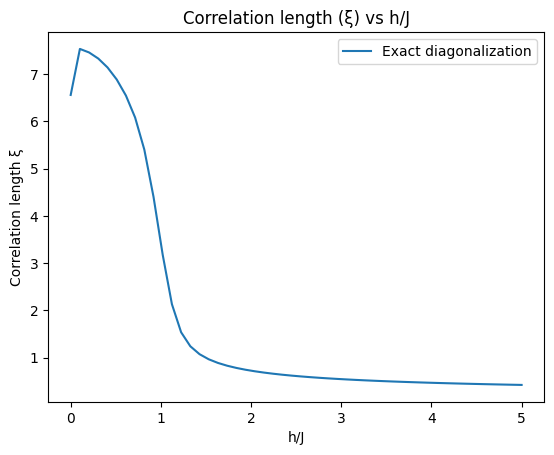

In [ ]:
import matplotlib.pyplot as plt

plt.title('Correlation length (ξ) vs h/J')
plt.xlabel('h/J')
plt.ylabel('Correlation length ξ')
plt.plot(h_J, correlation_len_exact, label='Exact diagonalization')
plt.legend()